# EE4211 Data Science for IoT Project

## Group Name: BeyondAI

#### Group Members:  

Chen Yiming (e0622334@u.nus.edu)  Matric No: A0226328E  
LIU XINGYU (e0506559@u.nus.edu)  Matric No: A0116430W  
YEAP CHUN LIK (e0319167@u.nus.edu)  Matric No: A0185876H  
ZHANG GUYU (e0506558@u.nus.edu)  Matric No: A0116427J

# Instructions:
In this project, you are given a dataset collected by an actual IoT system (see description below) and asked to use the dataset to build a forecasting model. You have to answer a set of questions, as well as propose your own interesting questions.
1. Form teams in groups of 4 students and select a name for your team. Be creative! Please email me your group members and team name.
2. Complete Question 1. Use a Jupyter notebook (ipynb file) to do the analysis and answer all the parts of the Question. Submit (i) PDF file/Print preview of your Jupyter note- book, and (ii) the Jupyter notebook (ipynb file). Zip both files into one zip file named as GroupName Question 1.zip and upload it to the appropriate LumiNUS folder.
3. Do the same for Question 2. Please name your file GroupName Question 2.zip and upload to LumiNUS.
4. Do the same for Question 3. For Question 3, please include a detailed description of your proposed work. Please name your file GroupName Question 3.zip and upload to LumiNUS.
5. The project carries a total of 40 marks: 30 marks for technical contributions (10 marks for
each question), and 10 marks for presentation.

# Data File:
The data file is available in the IVLE workbin under the directory ”Project Details”.

# Data Description:
In this project, we will consider natural gas consumption data from residential consumers. The smart gas meter data used for this paper was obtained from the Pecan Street project (https://www.pecanstreet.org/). The source of the data are homes in the Mueller neighbor- hood of Austin, Texas, USA. The homes in this neighborhood are primarily newly constructed, and include single-family homes, apartments, and town homes. Itron Centron SR smart gas meters are deployed in these homes and these meters send their information to a gateway inside the home. The gateway uses the home’s Internet connection to send the data to the meter data management system (MDMS) or the processing center. The gas meters measure the cumulative gas consumption at a frequency of 15 seconds. The meters report a reading (in terms of the cumulative consumption) when the last marginal 2 cubic foot (or higher) of natural gas passes through the meter. Data from a six month interval (1 Oct 2015 to 31 Mar 2016) has been provided. The data has the following format:
<Timestamp (localtime)> <MeterID (dataid)> <meter reading (meter_value)>
The timestamp provides the date as well as the the hour and minute values when each reading was taken. Each meter has an unique identifier (MeterID). Recall that the meter readings are cumulative and not generated at periodic intervals.

# Additional Information about Data Collection:
1. Gas flow meters have a sensor that is used to measure the volume of gas that passes though a pipe. Different meters use different sensors (e.g. ultrasonic sensors, synthetic diaphragm with rotating valve etc.). The meters check on the sensors periodically to get a reading of the current consumption value. This is what is meant in the sentence above: ”The gas meters measure the cumulative gas consumption at a frequency of 15 seconds.”
2. Now, just because the meter has obtained a reading from the sensors, it does not not have to send the reading off to the meter data management system (MDMS). Imagine 1.3 million households in Singapore sending out gas readings every 15 seconds to Singapore Power. The processing and bandwidth requirements may be too high for Singapore Power. So Singapore Power may wish for the meters to report at a lower frequency or when the consumption exceeds a certain threshold. However, the smart meter manufacturer does not know what is the reporting criterion of its users. So it builds meters that can read every 15 seconds because it thinks that this is a frequency that is high enough for all potential customers. The ”reporting” frequency to the MDMS (as opposed to the ”measuring” frequency) can be determined by the user of the meter such as Singapore Power.
3. So when are the meters supposed to ”report” to the MDMS? The documentation that came with the data says ”once the marginal consumption exceed 2 cubic meters”. As you may observe in the data, this is not necessarily the case in some of the readings. So is that an anomaly? That is for you to decide and justify. If you were Singapore Power, under what circumstances would you think that a meter reading is suspicious and decide to investigate? Remember that there are two sides to the story. If you do not receive a reading from a meter for a really long time, would you think that the meter is defective? So would that justify sending a reading even if the consumption has not increased?

# Questions:
## 3. Student Proposal (10 marks)
## Proposal 1
First load the data


In [265]:
# load necessary library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [266]:
# read original data and take out the seconds and UTC offset

data = pd.read_csv("dataport-export_gas_oct2015-mar2016.csv")
data['localminute'] = data['localminute'].astype(str).str[:19]
data['localminute'] = pd.to_datetime(data['localminute'])

In [267]:
# check the first 5 rows in the dataset

data.tail()

,localminute,dataid,meter_value
1584818,2016-03-31 23:59:14,2129,201726
1584819,2016-03-31 23:59:17,2945,161232
1584820,2016-03-31 23:59:35,9729,138146
1584821,2016-03-31 23:59:47,5129,166488
1584822,2016-03-31 23:59:58,484,114174


In [268]:
# check the data information of the dataset

print(data.info())
print('--------------------------------------------------------')
print(data.describe(include = "all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584823 entries, 0 to 1584822
Data columns (total 3 columns):
localminute    1584823 non-null datetime64[ns]
dataid         1584823 non-null int64
meter_value    1584823 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 36.3 MB
None
--------------------------------------------------------
                localminute        dataid   meter_value
count               1584823  1.584823e+06  1.584823e+06
unique              1499587           NaN           NaN
top     2015-12-05 20:57:14           NaN           NaN
freq                      6           NaN           NaN
first   2015-10-01 00:00:10           NaN           NaN
last    2016-03-31 23:59:58           NaN           NaN
mean                    NaN  4.352815e+03  2.015056e+05
std                     NaN  2.941902e+03  1.351182e+05
min                     NaN  3.500000e+01  2.829800e+04
25%                     NaN  1.714000e+03  1.145800e+05
50%                     NaN  

In [269]:
# check is there any null vales in the dataset

print("Number of null value is {}".format(data.isnull().sum()))

Number of null value is localminute    0
dataid         0
meter_value    0
dtype: int64


In [270]:
# create the list that contains all the meter ID

lstMeter = data['dataid'].unique()

In [271]:
# seperate all readings according to the meter ID

dictMeter = {c: pd.DataFrame(data[data['dataid']==c]) for c in lstMeter}

## Discussion: preprocessing the raw data first
Same as Q2, firstly clean the data and remove the outliers

Below are an example for meter ID 3544:  
![alt text](im1.png "Example image")  
We can see that there are some outliers malfunction readings during 2015-12 to 2016-01 and we should remove those outliers as it may affect our modeling.  

Cleaned example for meter ID 3544:  
![alt text](im2.png "Example image")  



In [272]:
# clean the original data and remove thoes ooutliers

dictMeter_clean = {}
for key in dictMeter:
    dictMeter_clean[key] = dictMeter[key].drop(dictMeter[key][dictMeter[key]['meter_value']>dictMeter[key].\
                        iloc[-1,:]['meter_value']].index)

In [273]:
# divide the 6 months time into 24h * 183d = 4392 segments. For each meter, get the average meter reading of all the
# readings within that segment. For example, segment 0 means period 2015-10-01 00:00:00 to 2015-10-01 01:00:00. So 
# the first reading is the average reading of all the readings in this period. After processing, all the meter will
# have the same length which is 4392 readings. If there is no reading for certain meter for certain time period, the 
# reading will be nan.

hourly_readings = {}
for key in dictMeter_clean:
    start_time = pd.Timestamp(year=2015, month=10, day=1)
    house_reading = dictMeter_clean[key]
    reading_arr = []
    for i in range(24*183):
        sub_row = house_reading[(house_reading['localminute']>(start_time+pd.Timedelta(hours=i))) & \
                                (house_reading['localminute']<(start_time+pd.Timedelta(hours=i+1)))]
        hourly_reading = sub_row['meter_value'].mean()
        reading_arr.append(hourly_reading)
    hourly_readings[key] = reading_arr

In [276]:
# transfer the array to dataframe

df = pd.DataFrame(hourly_readings)

In [277]:
# check the final completed data frame

df

,739,8890,6910,3635,1507,5810,484,4352,1718,1714,...,8244,2755,9600,2946,1403,7566,6673,2814,6101,4874
0,88858.0,197164.0,179118.0,151322.0,390354.000,97506.0,99298.000000,218216.0,161076.0,147048.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88858.0,197164.8,179118.0,151330.0,390354.000,97508.0,99299.428571,218216.0,161076.0,147048.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88859.0,NaN,179118.0,151330.0,390354.000,97508.0,99300.000000,218218.0,161076.0,147048.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88860.0,197166.0,179118.0,151330.0,390355.875,97508.0,99300.000000,NaN,161077.6,147051.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88860.0,197166.0,179118.0,151330.0,390356.000,97508.0,99302.222222,218218.0,161078.0,147058.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,103010.0,227306.0,NaN,170805.0,422680.000,115248.8,114168.500000,NaN,180958.0,170164.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,85354.0,NaN,NaN,NaN
4388,103011.0,NaN,205218.0,170806.0,422690.500,115254.0,114171.538462,NaN,180958.0,170164.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,85356.0,NaN,NaN,NaN
4389,103012.0,227308.0,205222.0,170806.0,422696.000,115270.0,114172.000000,NaN,180966.0,170164.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4390,103012.0,NaN,205224.0,170806.0,422704.000,115270.0,114172.000000,NaN,180980.0,170164.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
# build the model and do the prediction using linear regression

time_arr = []
start_time = pd.Timestamp(year=2015, month=10, day=1, hour=0)

for i in range(4392):
    time_arr.append(start_time + pd.Timedelta(hours=i))
    
hour_dict = {}
    
for key in df:
    reg = LinearRegression().fit(np.array(df[key].dropna().index).reshape(-1,1), df[key].dropna())
    
    time_arr0 = time_arr
    index = df[key].index[df[key].apply(np.isnan)]
    index = list(index)
    time_arr0 = np.delete(time_arr, index)
    """
    fig, axs = plt.subplots(2, 1, figsize=(20,8))
    axs[0].plot(np.array(df[key].dropna().index).reshape(-1,1), \
             reg.predict(np.array(df[key].dropna().index).reshape(-1,1)), color='r')
    axs[0].scatter(range(4392), df[key], color='b', s=1)
    axs[0].set_title("Meter ID {} Average Hourly Meter Reading".format(key))

    axs[1].plot(time_arr0, \
             reg.predict(np.array(df[key].dropna().index).reshape(-1,1)), color='r')
    axs[1].scatter(dictMeter_clean[key]["localminute"], dictMeter_clean[key]["meter_value"], color='g', s=1)
    axs[1].set_title("Meter ID {} Actual Meter Reading".format(key))

    plt.tight_layout()
    axs[0].legend(["LR Fitting Line", "Average Hourly Reading"])
    axs[1].legend(["LR Fitting Line", "Actual Meter Reading"])
    plt.show()
    print("The accuracy score of fitting for meter ID {} is {}"\
          .format(key, reg.score(np.array(df[key].dropna().index).reshape(-1,1), df[key].dropna())))
    print("The next predicted average hourly reading for meter ID {} for the period 2016-04-01 00:00:00 to 01:00:00 is {}"\
          .format(key, reg.predict(np.array([[4392]]))[0]))
    print("The average hourly consumption for meter ID {} is {}".format(key, (reg.predict(np.array([[4393]]))-reg.predict(np.array([[4392]])))[0]))
    print("-------------------------------------------------------------------------------------------------------------")
    """
    hour_dict[key] = (reg.predict(np.array([[4393]]))-reg.predict(np.array([[4392]])))[0]

Text(0.5, 1.0, 'Predicted Average Hourly Consumption for each home')

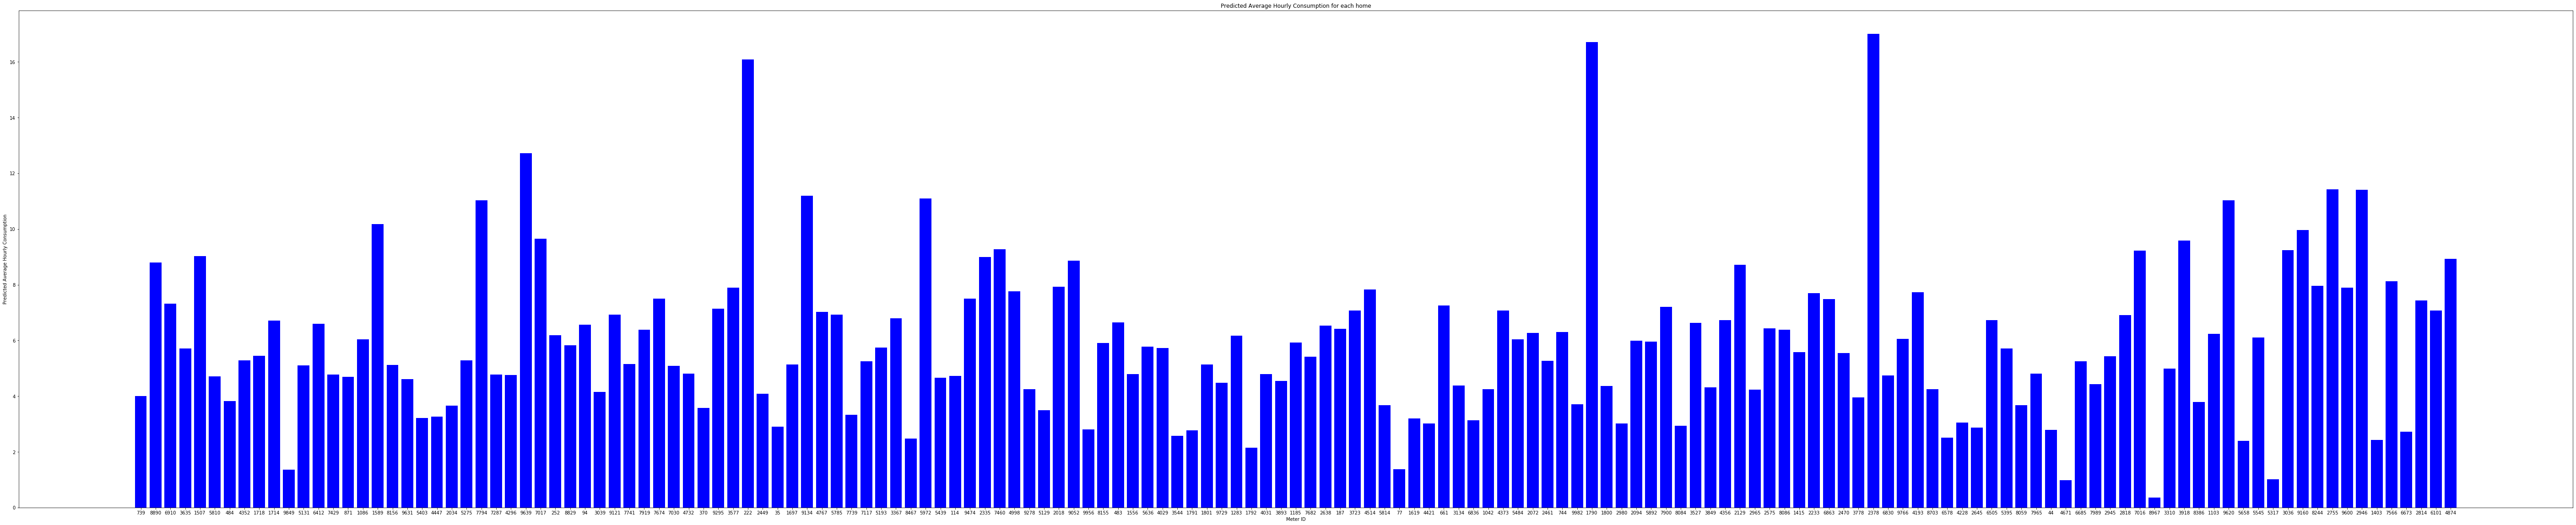

In [279]:
# plot the predicted average hourly consumption for all homes

plt.figure(figsize=(100,20))
readingLst = [i for i in list(hour_dict.values())]
meterLst = [str(i) for i in list(hour_dict.keys())]
plt.bar(meterLst,readingLst,color="b",label="Predicted Average Hourly Consumption for each home using Linear Regression")
plt.xlabel("Meter ID")
plt.ylabel("Predicted Average Hourly Consumption")
plt.title("Predicted Average Hourly Consumption for each home")

# Discussion
We would like to divide all 157 homes into 4 categories based on the average monthly consumption. 30% of homes will fall in low consumption tier, 30% of homes will fall in medium consumption tier, 30% of homes will fall in high consumption tier and the rest 10% of homes will fall in extremely high consumption tier.  

**Low consumption tier 1:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 - 3348  
**Medium consumption tier 2:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3348 - 4612.8  
**High consumption tier 3:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4612.8 - 6859.68  
**Extremely high consumption 4:** &nbsp;&nbsp;&nbsp;&nbsp;6859.68 and above  

There are 47 homes fall in tier 1, 47 homes fall in tier 2, 47 homes fall in tier 3 and 16 homes fall in tier 4. Please refer to below for the details of homes meter ID for each tier.


To utilise the energy more efficiently and encourage families to save and reduce the waste of energy, The gas company can set plans of different price per cubic meter for different tiers from low to high.

For example, gas price for tier 1 is 0.5 dollar per cubic meter, 0.6 dollar per cubic meter for tier 2, 0.7 dollar per cubic meter for tier 3 and 1 dollar per cubic meter for tier 4. If your family consumption for this month is 4000, then you should pay 0.5*3348 + 0.6*(4000-3348) = 2065.2 dollars for this month.  

## To do in the future  
1. As all the results are based on the lienar model of prediction, we can imporve our prediction to better fit the model. Please refer to below improvement part.

2. We should also consider the if one family has more members, the family is supposed to consume more gas per month, so the next step is to gather the information of family members for all the 157 families. Then we can get the more accurate data by calculating the average monthly consumption per personale and set the price tiers.  

3. Moreover, according to the monthly consumption level of each home, the construction company can build more proper and better pipline when doing the maintenance or reconstruction.

In [280]:
# create the dataframe from the hourly consumption dictionary and sort the dataframe in ascending order

hour_df = pd.DataFrame.from_dict(hour_dict, orient='index', columns=['Hourly Reading'])
hour_df.sort_values(by='Hourly Reading', inplace=True)
hour_df

,Hourly Reading
8967,0.360368
4671,0.979432
5317,1.006564
9849,1.356889
77,1.369670
...,...
2755,11.428275
9639,12.714881
222,16.092826
1790,16.716645


In [281]:
# seperate the whole dataframe into 4 tiers according to the percentage

low_df = hour_df.iloc[0:47] # low 30% homes
med_df = hour_df.iloc[47:94] # medium 30% - 60% homes
high_df = hour_df.iloc[94:141] # high 60% - 90% homes
exhigh_df = hour_df.iloc[141:157] # extreme high 90% - 100% home

In [282]:
# get the 4 tiers consumption range

low_tier = [0, 4.5]
med_tier = [4.5, 6.2]
high_tier = [6.2, 9.22]
exhigh_tier = [9.22, 'above']

In [283]:
# count the number of families fall in each of tiers

low_count = low_df.count()['Hourly Reading']
med_count = med_df.count()['Hourly Reading']
high_count = high_df.count()['Hourly Reading']
exhigh_count = exhigh_df.count()['Hourly Reading']

In [284]:
# get each tier consumption range for a month assuming 31 days in a month

low_tier31 = [low_tier[0]*24*31, low_tier[1]*24*31]
med_tier31 = [med_tier[0]*24*31, med_tier[1]*24*31]
high_tier31 = [high_tier[0]*24*31, high_tier[1]*24*31]
exhigh_tier31 = [exhigh_tier[0]*24*31, exhigh_tier[1]]

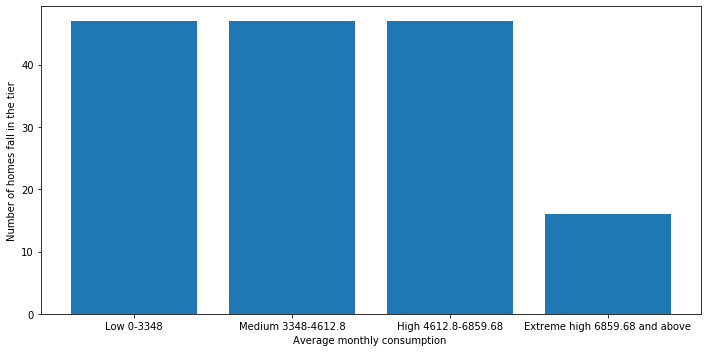

Number of homes fall in low consumption tier is 47, the meter ID is [8967, 4671, 5317, 9849, 77, 1792, 5658, 1403, 8467, 6578, 3544, 6673, 1791, 44, 9956, 2645, 35, 8084, 4421, 2980, 4228, 6836, 1619, 5403, 4447, 7739, 5129, 370, 2034, 5814, 8059, 9982, 8386, 484, 3778, 739, 2449, 3039, 2965, 1042, 8703, 9278, 3849, 1800, 3134, 7989, 9729]
-------------------------------------------------------------------------------------------------------------
Number of homes fall in medium consumption tier is 47, the meter ID is [3893, 9631, 5439, 871, 5810, 114, 6830, 4296, 7287, 7429, 4031, 1556, 4732, 7965, 3310, 7030, 5131, 8156, 1697, 1801, 7741, 7117, 6685, 2461, 5275, 4352, 7682, 2945, 1718, 2470, 1415, 5395, 3635, 4029, 5193, 5636, 8829, 8155, 1185, 5892, 2094, 1086, 5484, 9766, 5545, 1283, 252]
-------------------------------------------------------------------------------------------------------------
Number of homes fall in high consumption tier is 47, the meter ID is [1103, 2072, 744, 

In [285]:
# plot the bar chart for the 4 tiers and get all the homes meter ID for each of tiers

x_axis = ['Low 0-3348', 'Medium 3348-4612.8', 'High 4612.8-6859.68', 'Extreme high 6859.68 and above']
y_axis = [low_count, med_count, high_count, exhigh_count]
plt.figure(figsize=(10,5))
plt.bar(x_axis, y_axis)
plt.xlabel('Average monthly consumption ')
plt.ylabel('Number of homes fall in the tier')
plt.tight_layout()
plt.show()
print('Number of homes fall in low consumption tier is {}, the meter ID is {}'.format(low_count, list(low_df.index)))
print('-------------------------------------------------------------------------------------------------------------')
print('Number of homes fall in medium consumption tier is {}, the meter ID is {}'.format(med_count, list(med_df.index)))
print('-------------------------------------------------------------------------------------------------------------')
print('Number of homes fall in high consumption tier is {}, the meter ID is {}'.format(high_count, list(high_df.index)))
print('-------------------------------------------------------------------------------------------------------------')
print('Number of homes fall in extreme high consumption tier is {}, the meter ID is {}'.format(exhigh_count, list(exhigh_df.index)))

# Model Improvement Part

Below is our improved model to predict the daily consumption accross the 6 months for all the individual homes. We used **LSTM (long short-term memory)** model. We showed the first 10 homes meter for demonstration.

epoch:   1 loss: 0.04398124
epoch:  26 loss: 0.00025985
epoch:  51 loss: 0.00650813
epoch:  76 loss: 0.00255294
epoch: 101 loss: 0.00184251
epoch: 126 loss: 0.00090139
epoch: 149 loss: 0.0000961946


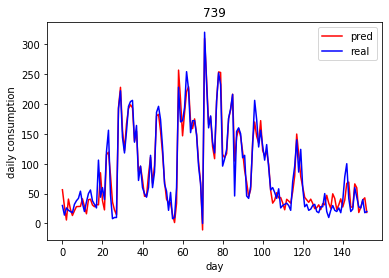

epoch:   1 loss: 0.02326862
epoch:  26 loss: 0.00620577
epoch:  51 loss: 0.00000001
epoch:  76 loss: 0.01310374
epoch: 101 loss: 0.01540042
epoch: 126 loss: 0.00045660
epoch: 149 loss: 0.0052261115


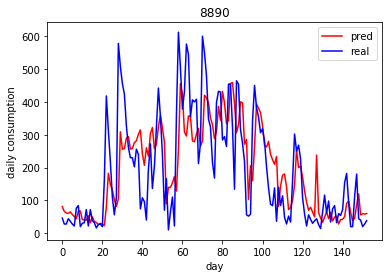

epoch:   1 loss: 0.04420021
epoch:  26 loss: 0.00038037
epoch:  51 loss: 0.00000284
epoch:  76 loss: 0.00329855
epoch: 101 loss: 0.02685077
epoch: 126 loss: 0.00368978
epoch: 149 loss: 0.0044701588


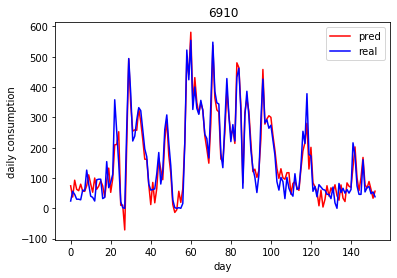

epoch:   1 loss: 0.00156483
epoch:  26 loss: 0.00000141
epoch:  51 loss: 0.00416336
epoch:  76 loss: 0.00542395
epoch: 101 loss: 0.00330202
epoch: 126 loss: 0.00269620
epoch: 149 loss: 0.0024086898


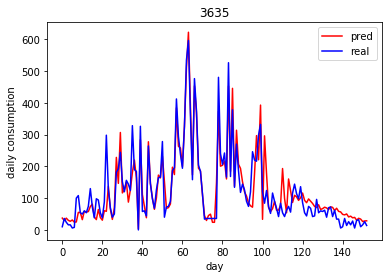

epoch:   1 loss: 0.05147930
epoch:  26 loss: 0.00655148
epoch:  51 loss: 0.01267585
epoch:  76 loss: 0.00021046
epoch: 101 loss: 0.00519592
epoch: 126 loss: 0.00925888
epoch: 149 loss: 0.0038447215


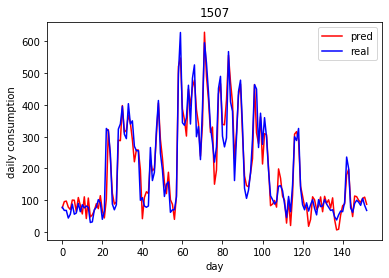

epoch:   1 loss: 0.00984569
epoch:  26 loss: 0.02209531
epoch:  51 loss: 0.06282237
epoch:  76 loss: 0.04155124
epoch: 101 loss: 0.04403833
epoch: 126 loss: 0.02124080
epoch: 149 loss: 0.0222013518


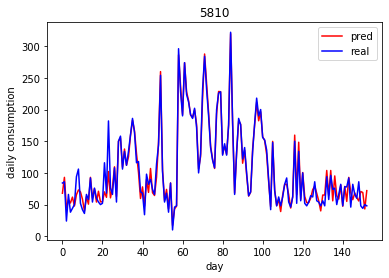

epoch:   1 loss: 0.10708092
epoch:  26 loss: 0.06553694
epoch:  51 loss: 0.06468331
epoch:  76 loss: 0.05946452
epoch: 101 loss: 0.07530762
epoch: 126 loss: 0.10952046
epoch: 149 loss: 0.0145193953


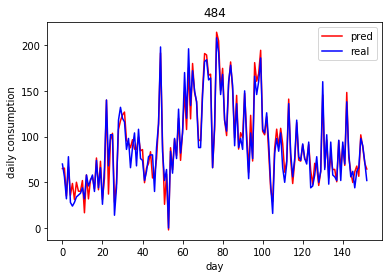

epoch:   1 loss: 0.00002735
epoch:  26 loss: 0.00046538
epoch:  51 loss: 0.00000478
epoch:  76 loss: 0.00000025
epoch: 101 loss: 0.00004230
epoch: 126 loss: 0.00012192
epoch: 149 loss: 0.0002039582


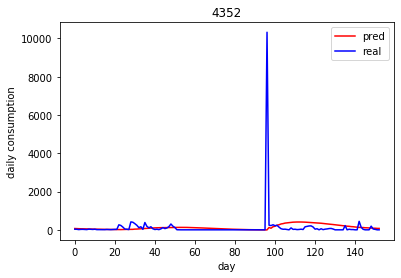

epoch:   1 loss: 0.00214029
epoch:  26 loss: 0.00140670
epoch:  51 loss: 0.00041599
epoch:  76 loss: 0.00090980
epoch: 101 loss: 0.00213046
epoch: 126 loss: 0.00167145
epoch: 149 loss: 0.0030836815


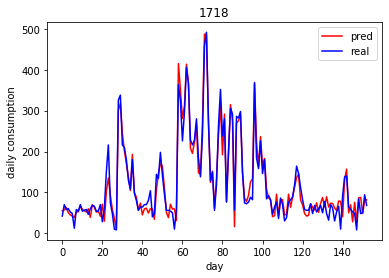

epoch:   1 loss: 0.06962930
epoch:  26 loss: 0.00007665
epoch:  51 loss: 0.05566140
epoch:  76 loss: 0.07088415
epoch: 101 loss: 0.00790488
epoch: 126 loss: 0.00674224
epoch: 149 loss: 0.0000206286


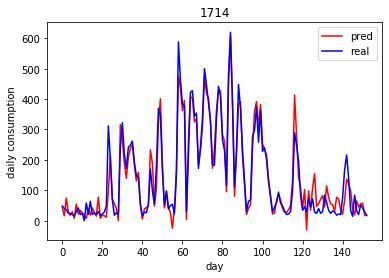

In [296]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler


# LSTM model used in our experiments with a single LSTM layer and a linear layer.
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


# use the raw daily consumption data to build input data, with the first element contain list of tw items corresponding to data in tw days, the second tuple element contains data in the tw+1st day
def create_input_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq


def train(epochs, model, train_inout_seq):
    # define loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    pred = []
    for i in range(epochs):
        model.train()
        for seq, labels in train_inout_seq:
            seq = seq
            labels = labels
            optimizer.zero_grad()
            # reset model hidden states
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)
            if i == epochs - 1:
                pred.append(y_pred.item())
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i % 25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return pred


def test(model, test_data, test_len, tw):
    # predict future consumption according to known consumption
    model.eval()
    model = model
    while len(test_data) < test_len:
        seq = torch.FloatTensor(test_data[-tw:])
        with torch.no_grad():
            # reset model hidden states
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_data.append(model(seq).item())
    return test_data


def read_data(data_path, unique_house):
    # read daily consumption data corresponding to a single house
    daily_reading = np.zeros(183)
    csv_data = pd.read_csv(data_path,
                           date_parser=lambda x: datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'),
                           parse_dates=['localminute'])
    start_time = pd.Timestamp(year=2015, month=10, day=1)
    house_reading = csv_data[csv_data['dataid'] == unique_house].\
        sort_values(by='localminute', ascending=True).reset_index()
    for i in range(183):
        start_row = house_reading[house_reading['localminute'] < start_time + pd.Timedelta(days=i)].reset_index()
        if len(start_row) > 0:
            start_row = start_row.iloc[-1]
        else:
            continue
        end_row = house_reading[house_reading['localminute'] < start_time + pd.Timedelta(days=i+1)].reset_index()
        if len(end_row) > 0:
            end_row = end_row.iloc[-1]
        else:
            continue
        daily_reading[i] += end_row['meter_value'] - start_row['meter_value']

    return daily_reading


def main():
    data_path = 'dataport-export_gas_oct2015-mar2016.csv'
    csv_data = pd.read_csv(data_path,
                           date_parser=lambda x: datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'),
                           parse_dates=['localminute'])
    unique_houses = csv_data['dataid'].unique()
    for unique_house in unique_houses[:10]:
        train_data = read_data(data_path, unique_house)
        
        # nomarlize data with minmaxscaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_data_transformed = scaler.fit_transform(train_data.reshape(-1, 1))
        train_data_transformed = torch.FloatTensor(train_data_transformed).view(-1)

        # input sequence length is set to 30, since we are using daily consumption data, and there are about 30 days in a month
        train_window = 30
        train_seq = create_input_sequences(train_data_transformed, train_window)

        model = LSTM(input_size=1,
                     hidden_layer_size=256,
                     output_size=1)
        pred = train(150, model, train_seq)
        real = []
        for item in train_seq:
            real.append(item[1].item())

        # recover real data from normalized data
        real = scaler.inverse_transform(np.array(real).reshape(-1, 1))[:, 0].tolist()
        pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))[:, 0].tolist()

        # plot real and predicted daily consumption 
        x = [i for i in range(len(pred))]
        plt.plot(x, pred, color='r', label='pred')
        plt.plot(x, real, color='b', label='real')
        plt.xlabel('day')
        plt.ylabel('daily consumption')
        plt.title(str(unique_house))
        plt.legend()
        plt.show()


if __name__ == '__main__':
    main()
